In [1]:
from datasets import load_dataset

ds = load_dataset("Bingsu/Human_Action_Recognition")
ds


README.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [2]:
converter = {
    'calling': 0,
    'clapping': 1,
    'cycling': 2,
    'dancing': 3,
    'drinking': 4,
    'eating': 5,
    'fighting': 6,
    'hugging': 7,
    'laughing': 8,
    'listening_to_music': 9,
    'running': 10,
    'sitting': 11,
    'sleeping': 12,
    'texting': 13,
    'using_laptop': 14
}

In [3]:
list(converter.keys())

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [4]:
ds['train'][12]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=231x218>,
 'labels': 1}

In [5]:
from sklearn.model_selection import train_test_split
indexes = [i for i in range(len(ds['train']))]
train_id,val_id = train_test_split(indexes,test_size=0.2,random_state =42)

In [202]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm


def get_preds(ids,prefixs, model_name = "openai/clip-vit-base-patch32",split = 'train',):
    model = CLIPModel.from_pretrained(model_name).to('cuda')
    processor = CLIPProcessor.from_pretrained(model_name)
    
    size= len(ids)
    texts = []
    for j in prefixs:
        texts.extend([j +' '+ i for i in list(converter.keys())])
    preds = []
    batch = 128
    for start in tqdm(range(0,size,batch)):
        end = min(start+batch,size)
        images = ds[split][ids[start:end]]['image']
        inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
        inputs = {k : v.to('cuda') for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image 
            probs = logits_per_image.softmax(dim=1)
        preds.extend(probs)
    print(len(preds[0]))
    return preds


In [311]:
import pandas as pd
train = pd.DataFrame({'target':ds['train'][train_id]['labels']})

prefixes = [
    "a photo of a person who is",
    "a picture of someone who is",
    "an image of a person",
    "a person shown while",
    "a person captured in the act of",
    "someone is currently",
    "a human is seen",
    "an individual is now",
    "a person can be seen",
    "a snapshot of a person",
    "this person ",
    " ",
    "a video of a person",
    "a person engaged in",
    "a human performing",
    "an individual involved in",
    "a depiction of someone",
    "a scene showing a person",
    "a person in the midst of",
    "a person actively",
    "a person caught while",
    "a person is",
    "someone is",
    "a human is",
    "an individual is",
    "a person performing",
    "someone performing",
    "a human performing",
    "an individual performing",
    "a person engaged in",
    "someone engaged in",
    "a human engaged in",
    "an individual engaged in",
    "a person involved in",
    "someone involved in",
    "a human involved in",
    "an individual involved in",
    "a person seen",
    "someone seen",
    "a human seen",
    "an individual seen",
    "a person captured",
    "someone captured",
    "a human captured",
    "an individual captured",
    "a person observed"
]

prefixes += [
    "a person is currently",
    "someone appears to be",
    "an individual caught in the moment of",
    "a human being engaged in",
    "a candid moment of someone",
    "a subject in the middle of",
    "someone depicted while",
    "an individual caught doing",
    "a moment showing someone who is",
    "a human figure shown while",
    "a person featured in the act of",
    "a figure is seen",
    "a person was observed",
    "one can see someone",
    "there is a person who is",
    "someone caught red-handed while",
    "the person on screen is",
    "footage showing a person",
    "in the clip, someone is",
    "captured on camera: a person",
    "what we see is a person",
    "a person mid-action",
    "a human caught mid-act",
    "someone mid-movement",
    "an individual shown in motion",
    "a snapshot revealing someone",
    "a clear example of someone",
    "caught in a moment: someone",
    "an everyday person, currently",
    "a generic figure is",
    "a being who is",
    "a human subject is now",
    "someone performing the action of",
    "a moment where someone is",
    "this still shows someone who is",
    "in this scene, a person is",
    "a person doing",
    "here, someone is",
    "we see someone",
    "the focus is on a person who is",
    "a still of a person in action",
    "in this frame, someone is",
    "recorded on video: a person who is",
    "an anonymous figure is",
    "a video still featuring someone",
    "a figure currently engaged in",
    "a human acting out",
    "a visual of someone",
    "someone in the act of",
    "someone is taking part in"
]

dop_pref = ['the image has']
key_words = [
    "smartphone",        # для calling, texting
    # "headphones",        # для listening_to_music
    # "bicycle",           # для cycling
    # "dance_floor",       # для dancing
    # "coffee_cup",        # для drinking
    # "hamburger",         # для eating
    # "boxing_gloves",     # для fighting
    # "couch",             # для sitting, hugging
    # "bed",               # для sleeping
    # "laptop",            # для using_laptop
    # "keyboard",          # для texting, using_laptop
    # "stage",             # для clapping, dancing
    # "park",              # для running, cycling
    # "friends",           # для hugging, laughing
    # "dining_table"       # для eating, drinking
]
preds = get_preds(train_id, prefixes)
features = np.array(torch.stack(preds).cpu()).tolist()

preds1 = get_preds(train_id, prefixes,'openai/clip-vit-base-patch16')
features1 = np.array(torch.stack(preds1).cpu()).tolist()

preds2 = get_preds(train_id, prefixes,'openai/clip-vit-large-patch14')
features2 = np.array(torch.stack(preds2).cpu()).tolist()
# переводим на CPU (если нужно), разъединяем градиенты и конвертируем в списки
# features: list[list[float]] = preds.detach().cpu().tolist()
# features1 = [[float(j) for j in i] for i in get_preds(train_id,prefixes,'openai/clip-vit-base-patch16')]
# features2 = [[float(j) for j in i] for i in get_preds(train_id,prefixes,'openai/clip-vit-large-patch14')]
# train['features'] = [float(i) for i in get_preds(train_id,prefixes)]
# train['features1'] = [[float(j) for j in i] for i in get_preds(train_id,prefixes,'openai/clip-vit-base-patch16')]
# train['features2'] = [[float(j) for j in i] for i in get_preds(train_id,prefixes,'openai/clip-vit-large-patch14')]
train.head()

100%|██████████| 79/79 [00:47<00:00,  1.66it/s]


1440


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


1440


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 79/79 [04:42<00:00,  3.57s/it]


1440


,target
0,2
1,4
2,1
3,13
4,2


In [330]:
features1 = np.array(torch.stack(preds1).cpu()).tolist()
features2 = np.array(torch.stack(preds2).cpu()).tolist()

In [367]:
clip_preds =[]
arr = np.array(features)
for i in range(len(prefixes)):
    clip_preds.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

clip_preds1 =[]
arr = np.array(features1)
for i in range(len(prefixes)):
    clip_preds1.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

clip_preds2 =[]
arr = np.array(features2)
for i in range(len(prefixes)):
    clip_preds2.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

In [368]:
%%capture
import numpy as np

cols_pred = [f'preds_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds)
for i in range(len(clip_preds)):
    train[f'preds_{i}'] = arr[i,:]

cols_pred1 = [f'preds1_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds1)
for i in range(len(clip_preds1)):
    train[f'preds1_{i}'] = arr[i,:]

cols_pred2 = [f'preds2_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds2)
for i in range(len(clip_preds2)):
    train[f'preds2_{i}'] = arr[i,:]

In [340]:
%%capture
import numpy as np
cols_name = [f'f_{i}' for i in range(len(features[0]))]
arr = np.array(features)
for i in range(len(features[0])):
    train[f'f_{i}'] = arr[:,i]

cols_name1 = [f'f1_{i}' for i in range(len(features1[0]))]
arr = np.array(features1)
for i in range(len(features1[0])):
    train[f'f1_{i}'] = arr[:,i]

cols_name2 = [f'f2_{i}' for i in range(len(features2[0]))]
arr = np.array(features2)
for i in range(len(features2[0])):
    train[f'f2_{i}'] = arr[:,i]

In [386]:
cols = ['features']
X = train[cols_name2+cols_pred2]# + cols_name1 + cols_name2]
y = train[['target']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state =42)

In [387]:
from catboost import CatBoostClassifier

ctb = CatBoostClassifier(verbose = 50,iterations=500,task_type='GPU')
ctb.fit(X_train,y_train,eval_set=(X_test,y_test))

Learning rate set to 0.175769
0:	learn: 1.9949895	test: 2.0035118	best: 2.0035118 (0)	total: 55.8ms	remaining: 27.8s
50:	learn: 0.2505729	test: 0.3133623	best: 0.3133623 (50)	total: 3.52s	remaining: 31s
100:	learn: 0.1878185	test: 0.2883915	best: 0.2883915 (100)	total: 6.68s	remaining: 26.4s
150:	learn: 0.1491652	test: 0.2770604	best: 0.2770144 (149)	total: 9.8s	remaining: 22.7s
200:	learn: 0.1194787	test: 0.2674047	best: 0.2674047 (200)	total: 12.8s	remaining: 19.1s
250:	learn: 0.0990879	test: 0.2636462	best: 0.2636462 (250)	total: 15.8s	remaining: 15.7s
300:	learn: 0.0807373	test: 0.2605897	best: 0.2605897 (300)	total: 18.8s	remaining: 12.4s
350:	learn: 0.0669539	test: 0.2585034	best: 0.2585034 (350)	total: 21.8s	remaining: 9.24s
400:	learn: 0.0560229	test: 0.2564912	best: 0.2564912 (400)	total: 24.8s	remaining: 6.12s
450:	learn: 0.0474319	test: 0.2572418	best: 0.2564341 (428)	total: 27.8s	remaining: 3.02s
499:	learn: 0.0408240	test: 0.2576424	best: 0.2564341 (428)	total: 30.8s	remai

In [380]:
from sklearn.metrics import accuracy_score
accuracy_score(ctb.predict(X_test),y_test)

0.9325396825396826

In [ ]:
0.8829365079365079
0.9246031746031746
0.9315476190476191
0.9325396825396826

In [ ]:
0.8759920634920635

In [ ]:
0.8764880952380952

In [ ]:
0.8685515873015873
0.8685515873015873

In [120]:
from catboost import Pool
train_pool = Pool(data=X_test,label=y_test)
print(X_train.columns)
f_imp = ctb.get_feature_importance(train_pool)
norm_features = []

threshold = 0.05
for i in range(len(f_imp)):
    if (f_imp[i] > threshold):
        norm_features.append(X_train.columns[i])

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_306', 'f_307', 'f_308', 'f_309', 'f_310', 'f_311', 'f_312', 'f_313',
       'f_314', 'f_315'],
      dtype='object', length=316)


In [121]:
len(norm_features)

280

In [ ]:
0.8759920634920635

In [ ]:
0.8754960317460317

In [ ]:
0.8506944444444444
0.8898809523809523
0.9052579365079365

In [26]:
len(ds['test'])

5400

In [345]:
preds = get_preds(val_id, prefixes)
features_test = np.array(torch.stack(preds).cpu()).tolist()

preds1 = get_preds(val_id, prefixes,'openai/clip-vit-base-patch16')
features1_test = np.array(torch.stack(preds1).cpu()).tolist()

preds2 = get_preds(val_id, prefixes,'openai/clip-vit-large-patch14')
features2_test = np.array(torch.stack(preds2).cpu()).tolist()

100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


1440


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


1440


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


1440


In [381]:
clip_preds =[]
arr = np.array(features_test)
for i in range(len(prefixes)):
    clip_preds.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

clip_preds1 =[]
arr = np.array(features1_test)
for i in range(len(prefixes)):
    clip_preds1.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

clip_preds2 =[]
arr = np.array(features2_test)
for i in range(len(prefixes)):
    clip_preds2.append(np.argmax(arr[:,i*15:(i+1)*15],axis=1))

In [383]:
%%capture
import numpy as np

cols_pred = [f'preds_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds)
for i in range(len(clip_preds)):
    test[f'preds_{i}'] = arr[i,:]

cols_pred1 = [f'preds1_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds1)
for i in range(len(clip_preds1)):
    test[f'preds1_{i}'] = arr[i,:]

cols_pred2 = [f'preds2_{i}' for i in range(len(clip_preds))]
arr = np.array(clip_preds2)
for i in range(len(clip_preds2)):
    test[f'preds2_{i}'] = arr[i,:]

In [346]:
%%capture
import numpy as np
test = pd.DataFrame({'target':ds['train'][val_id]['labels']})
arr = np.array(features_test)
for i in range(len(features_test[0])):
    test[f'f_{i}'] = arr[:,i]

arr = np.array(features1_test)
for i in range(len(features1_test[0])):
    test[f'f1_{i}'] = arr[:,i]

arr = np.array(features2_test)
for i in range(len(features2_test[0])):
    test[f'f2_{i}'] = arr[:,i]

In [388]:
test['preds'] = ctb.predict(test[cols_name2+cols_pred2])

In [389]:
from sklearn.metrics import f1_score,classification_report
print('acc: ',accuracy_score(test['target'],test['preds']))
print('f1: ', f1_score(test['target'],test['preds'],average='weighted'))

acc:  0.9166666666666666
f1:  0.9165897459103067


In [422]:
from IPython.display import Markdown
Markdown(classification_report(test['target'],test['preds'],digits=4))

              precision    recall  f1-score   support

           0     0.8901    0.9364    0.9127       173
           1     0.9085    0.9313    0.9198       160
           2     0.9946    0.9946    0.9946       186
           3     0.9663    0.9556    0.9609       180
           4     0.9379    0.8947    0.9158       152
           5     0.9051    0.9470    0.9256       151
           6     0.9676    0.9624    0.9650       186
           7     0.9400    0.9338    0.9369       151
           8     0.8833    0.8883    0.8858       179
           9     0.8852    0.9205    0.9025       176
          10     0.9739    0.9613    0.9675       155
          11     0.7927    0.7975    0.7951       163
          12     0.9739    0.9198    0.9460       162
          13     0.8841    0.7923    0.8357       183
          14     0.8514    0.9141    0.8817       163

    accuracy                         0.9167      2520
   macro avg     0.9170    0.9166    0.9164      2520
weighted avg     0.9174    0.9167    0.9166      2520


In [55]:
converter

{'calling': 0,
 'clapping': 1,
 'cycling': 2,
 'dancing': 3,
 'drinking': 4,
 'eating': 5,
 'fighting': 6,
 'hugging': 7,
 'laughing': 8,
 'listening_to_music': 9,
 'running': 10,
 'sitting': 11,
 'sleeping': 12,
 'texting': 13,
 'using_laptop': 14}

In [411]:
train[train['target']==14].index

Index([   39,    67,   112,   135,   141,   153,   156,   158,   170,   176,
       ...
        9907,  9913,  9944,  9983,  9989,  9992, 10009, 10051, 10070, 10074],
      dtype='int64', length=677)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
import numpy as np
import random
import os
from PIL import Image

ann_file = 'path/to/annotations.json' 
coco = COCO(ann_file)
def visualize_coco_segmentation(coco, catIds=[], imgIds=[], show_bbox=True, show_mask=True):

    if not imgIds:
        imgIds = coco.getImgIds()
    

    img_id = random.choice(imgIds)
    img_info = coco.loadImgs(img_id)[0]
    
    img_path = os.path.join('path/to/images', img_info['file_name'])
    image = np.array(Image.open(img_path))
    
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=catIds)
    annotations = coco.loadAnns(ann_ids)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    
    for ann in annotations:

        if show_bbox:
            bbox = ann['bbox']  
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2], bbox[3],
                linewidth=2, 
                edgecolor='r', 
                facecolor='none'
            )
            ax.add_patch(rect)
        
        if show_mask and 'segmentation' in ann:
            if type(ann['segmentation']) == list:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((-1, 2))
                    patch = patches.Polygon(
                        poly, 
                        closed=True, 
                        edgecolor='lime', 
                        facecolor='none', 
                        linewidth=2
                    )
                    ax.add_patch(patch)
            else:
                from pycocotools import mask as maskUtils
                mask = maskUtils.decode(ann['segmentation'])
                color_mask = np.random.random(3)
                ax.imshow(np.dstack((mask, mask, mask)) * color_mask, alpha=0.5)   
    if annotations:
        cat_ids = [ann['category_id'] for ann in annotations]
        cats = coco.loadCats(cat_ids)
        for i, (ann, cat) in enumerate(zip(annotations, cats)):
            ax.text(
                ann['bbox'][0], 
                ann['bbox'][1] - 10, 
                cat['name'], 
                color='white', 
                bbox=dict(facecolor='red', alpha=0.8))
    
    plt.axis('off')
    plt.title(f"Image ID: {img_id}")
    plt.tight_layout()
    plt.show()

visualize_coco_segmentation(coco)


cat_ids = coco.getCatIds(catNms=['person', 'car'])
visualize_coco_segmentation(coco, catIds=cat_ids)

In [ ]:

def visualize_yolo_bboxes(image_path, label_path, class_names=None, color=(0, 255, 0), thickness=2):
    """
    Визуализация YOLO bbox на изображении
    
    Параметры:
        image_path: путь к изображению
        label_path: путь к файлу с аннотациями YOLO (.txt)
        class_names: список названий классов
        color: цвет bbox (BGR)
        thickness: толщина линии
    """
    image = cv2.imread(image_path)

    
    img_height, img_width = image.shape[:2]
    

    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 5:
            continue
            
        class_id = int(parts[0])
        x_center = float(parts[1]) * img_width
        y_center = float(parts[2]) * img_height
        width = float(parts[3]) * img_width
        height = float(parts[4]) * img_height
        
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

        label = class_names[class_id] if class_names else str(class_id)
        cv2.putText(image, label, (x_min, y_min - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

2


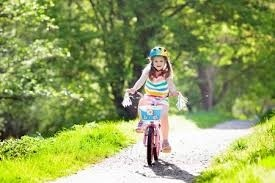

2


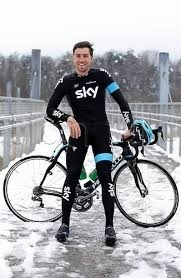

2


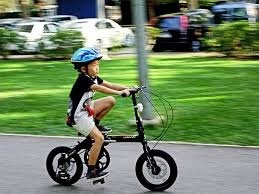

2


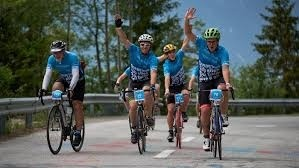

2


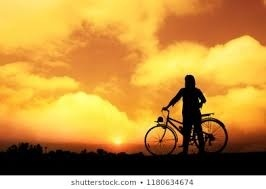

2


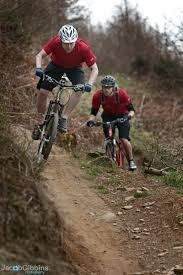

2


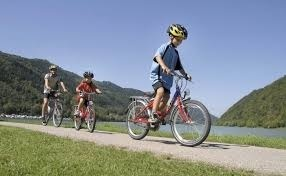

2


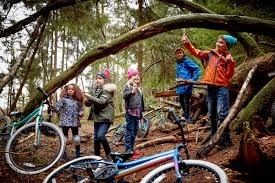

2


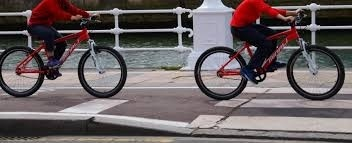

2


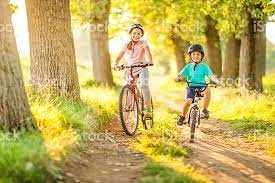

2


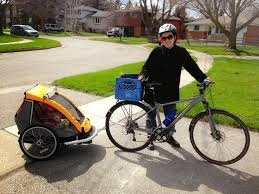

2


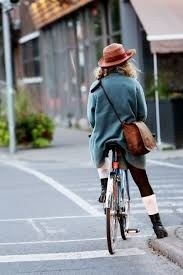

2


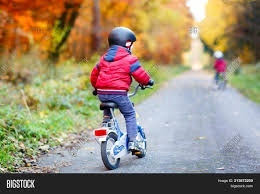

2


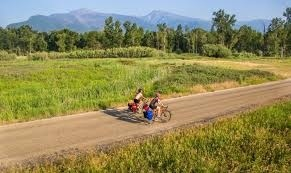

2


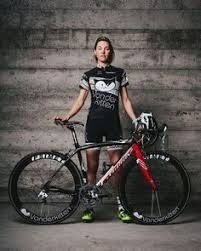

2


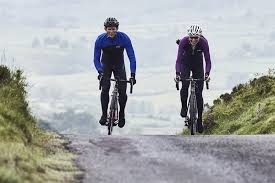

2


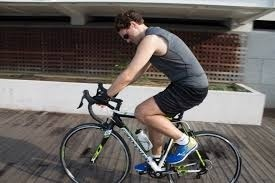

2


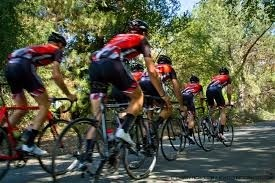

2


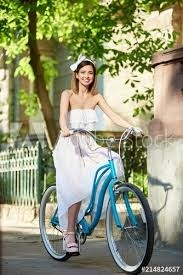

2


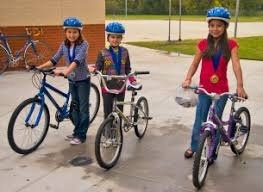

2


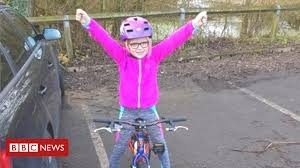

2


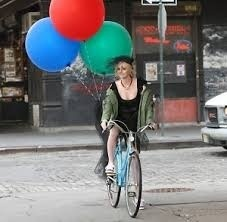

2


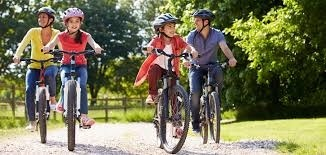

2


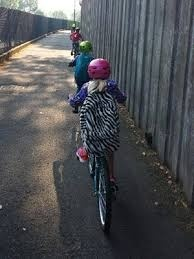

2


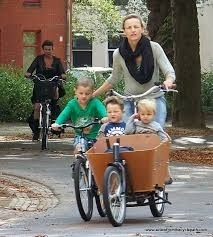

In [421]:
from IPython.display import display
indexes = test[test['target']==2].index
for i in range(25,50):
    n=val_id[indexes[i]]
    print(ds['train'][n]['labels'])
    display(ds['train'][n]['image'])

In [ ]:
0.8345238095238096
0.8511904761904762
0.8873015873015873

In [121]:
from datasets import DatasetDict
from sklearn.model_selection import train_test_split

# Предположим, что ds уже загружен, и у нас есть train_id и val_id
train_ids, val_ids = train_test_split(train_id, test_size=0.15, random_state=42)

train_ds = ds['train'].select(train_ids)
val_ds = ds['train'].select(val_ids)

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds
})


In [122]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8568
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 1512
    })
})

In [126]:
len(set(dataset['train'][:]['labels']))

15

In [116]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from datasets import load_dataset
from PIL import Image

# 1. Load your dataset (Hugging Face Datasets format)
dataset_dict = dataset
# 2. Define transforms based on the pretrained weights' recommended preprocessing
weights = EfficientNet_B4_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

# 3. Preprocess dataset with map to add pixel values tensor

def preprocess_fn(example):
    img = example['image']
    # Handle possible list of images
    if isinstance(img, list):
        img = img[0]
    # Convert to PIL.Image if needed
    if not isinstance(img, Image.Image) and hasattr(img, 'to_pil'):
        img = img.to_pil()
    example['pixel_values'] = preprocess(img)
    return example

# Apply preprocessing in-place
dataset_dict = dataset_dict.map(preprocess_fn)

# 4. Set dataset format to PyTorch tensors and select only needed columns
columns = ['pixel_values', 'labels']
dataset_dict.set_format(type='torch', columns=columns)

# 5. Create DataLoaders
batch_size = 16  # B4 is larger, you may need to reduce batch size to fit GPU memory
train_loader = DataLoader(dataset_dict['train'], batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(dataset_dict['validation'], batch_size=batch_size, shuffle=False, num_workers=4)

# 6. Initialize model with pretrained weights
model = efficientnet_b4(weights=weights)
num_features = model.classifier[1].in_features
num_classes = dataset_dict['train'].features['labels'].num_classes
# Replace the classification head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),  # higher dropout for larger model
    nn.Linear(num_features, num_classes)
)

# 7. Move model to device, set up loss, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW often works well
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

epochs = 10

# 8. Training and validation loops
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{epochs} - Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)
    print(f"Epoch {epoch}/{epochs} - Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}\n")

# 9. Save the fine-tuned model weights
torch.save(model.state_dict(), 'efficientnet_b4_finetuned.pth')
print("Training complete. Model saved to efficientnet_b4_finetuned.pth")


Map:   0%|          | 0/8568 [00:00<?, ? examples/s]

Map:   0%|          | 0/1512 [00:00<?, ? examples/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 200MB/s] 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid

Epoch 1/10 - Training Loss: 1.5726


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10 - Validation Loss: 0.7051, Accuracy: 0.7765



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

KeyboardInterrupt: 

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from PIL import Image
def visualize_coco_annotations(coco_data, image_id=None):
    # Загрузка JSON-файла
    
    # Если image_id не указан, выбираем первое изображение
    if image_id is None:
        image_info = coco_data['images'][0]
    else:
        image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
    
    # Загрузка изображения (путь должен быть правильным)
    if image_id is None:
        image_info = coco_data['images'][0]
    else:
        image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
    
    # Загрузка изображения с помощью PIL
    image = Image.open('/kaggle/input/feel-the-agi-again/val/val/'+image_info['file_name'])
    image = np.array(image)  # Конвертируем в numpy array для matplotlib
    
    # Получение всех аннотаций для этого изображения
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_info['id']]
    
    # Создание фигуры
    fig, ax = plt.subplots(1, figsize=(12, 8))
    print(len(annotations))
    # Отображение изображения
    ax.imshow(image)
    
    # Для каждой аннотации
    for ann in annotations:
        # Получение категории
        category = next(cat for cat in coco_data['categories'] if cat['id'] == ann['category_id'])
        
        # Обработка сегментации (может быть RLE или полигоны)
        if isinstance(ann['segmentation'], dict):
            # RLE маска
            mask = coco_mask.decode(ann['segmentation'])
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                poly = contour.flatten().tolist()
                polygon = Polygon(np.array(poly).reshape((-1, 2)), closed=True, 
                                fill=False, edgecolor='red', linewidth=1)
                ax.add_patch(polygon)
        else:
            # Полигоны
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((-1, 2))
                polygon = Polygon(poly, closed=True, 
                                fill=False, edgecolor='red', linewidth=1)
                ax.add_patch(polygon)
        
        # Добавление текста с именем категории
        if len(ann['segmentation']) > 0:
            x, y = poly[0]
            ax.text(x, y, category['name'], color='white', 
                   bbox=dict(facecolor='red', alpha=0.7))
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Пример использования
visualize_coco_annotations(json_data, image_id=42)